# Notebook for analyzing Insider tradings and the effects on stock prices
Written by Thomas Niedermayer and Gunnar Sjúrðarson Knudsen, as a conjoined effort for an interdiscplinary project in Data Science.

Supervisor: Wolfgang Aussenegg

Co-Supervisor: Sascha Hunold

Purpose of this notebook is XXX

## Remaining todos:
* Create README.md and add a diagram of the project
* T1_ vs T1!!!
* A lot!
* Figure out which custom functions we are still using
* Figure out if different hypotheses should be tested based on "NAME" - or do both do all analysis?
* Refactor - we have data locations in two different varialbes (CAPS and preceeding underscore)
* I MIGHT have deleted too much from data_checks.run
* Currently have two different datasets for the ReturnIndex data - with (linear) interpolation, as well as skipping rows that don't exist in market and company.
* Figure out what to do, when event date not in the dataset. Could still "just" do closest possible, provided that trades occur around the date.
* What do we do when tickers are non-unique!? I think this is a nasty that breaks more than we know
* document get_all_directors_dealings_async


### Hypotheses

#### Gunnar

1. Hypothesis 1: Insiders are able to earn significant abnormal returns in the first
weeks after disclosure.
2. Hypothesis 2: Trades of type “Purchase” are most explaining of abnormal return.
“Sale” less so, and “Sale + Option” does not have an effect.
3. Hypothesis 3: Directors have changed behaviour during the times of Covid.

#### Tom

1. Hypothesis 1: Insiders are able to earn significant abnormal returns in
the first weeks after disclosure of relevant information.
2. Hypothesis 2: Insiders are significantly good at avoiding risk indicated
by market downturns after insiders selling shares.
3. Hypothesis 3: Directors have changed behaviour during the times of
covid: Hypotheses 1 and 2 can be answered with significantly different
confidence before and during the pandemic.



## Setup

### Define which analysis is run
Add a name here. This affects which data is read in, as well as which analysis are done?

In [1]:
from tools import load_settings
settings = load_settings()
NAME = settings["NAME"]

### Load Libraries

In [2]:
# Standard libraries
import pickle
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import os
from tqdm import tqdm
from scipy import stats


# custom functions
import source.analyse_single_company as UASC
from source import data_checks, determine_T0_T1_T2, cut_timeseries, calculate_coefficients
import logging

logging.getLogger().setLevel(logging.WARNING)

#plt.style.use("seaborn")

### Read in the data

In [3]:
# Data locations
DATA_LOCATION = f'data/{NAME}/'
DATA_LOCATION_INSIDER_PROCESSED = DATA_LOCATION + 'processed/insider/'
DATA_LOCATION_RI = DATA_LOCATION + 'processed/RI_discard/'

# set plotting sizes
tick_size = 15
label_size = 20
title_size = 30
fig_height = 20

investigation_periods = settings["investigation_periods"]
keys = list(investigation_periods.keys())
interval_borders = [investigation_periods[keys[0]][0], investigation_periods[keys[1]][1], investigation_periods[keys[0]][1]]
# Read in the summary data from "CompaniesToExclude" notebook
summary_data = pd.read_csv(DATA_LOCATION + '/scraping_summary.csv', index_col=0)
# Generate list of which companies to analyse
isins_to_use = summary_data[summary_data['reason_to_exclude'] == 'None']['ISIN CODE'].to_list()
display(summary_data)
print(f'We want to reduce to {len(isins_to_use)} isins')


## Not sure why we do this - maybe refactor
_ri_location = DATA_LOCATION_RI
_insider_location = DATA_LOCATION_INSIDER_PROCESSED

# Get locations to read in
file_locs_ = os.listdir(_ri_location)
print(f'Found {len(file_locs_)} possible files to analyze')
# Filter files for analysis, and append path:
file_locs = [_ri_location + f for f in file_locs_ if f[:-7] in isins_to_use]
print(f'We are left with {len(file_locs)} to analyze')

# Actually read in the company information
companies = []
print("loading return series...")
for file_loc in tqdm(file_locs):
    with open(file_loc, "rb") as f:
        company = pickle.load(f)
    companies.append(company)

,ISIN CODE,NAME,TICKER SYMBOL,trade_count,n_distinct_traders,n_distinct_trade_types,ts_rows,reason_to_exclude
764,US35953D1046,FUBOTV,FUBO,40,8,7,1509.0,Faulty timeseries data
954,US46124J2015,INVENTRUST PROPERTIES,IVT,4,4,1,1509.0,Faulty timeseries data
1939,NaN,ABOVENET 'B',ABVT,179,21,10,824.0,Missing ISIN
2093,NaN,ATHENA CONSUMER ACQUISITION CL B,ACAQ,1,1,1,824.0,Missing ISIN
2062,NaN,ARCTIC CAT 'B' DEAD - 07/03/17,ACAT,446,33,8,824.0,Missing ISIN
...,...,...,...,...,...,...,...,...
1057,US53228T1016,LIGHTNING EMOTORS,ZEV,16,13,5,430.0,None
3636,US98979J1097,ZOES KITCHEN DEAD - DELIST.21/11/18,ZOES,87,17,8,675.0,None
1923,US98978V1035,ZOETIS A,ZTS,499,34,8,1509.0,None
1926,US98983L1089,ZURN WATER SOLUTIONS,ZWS,526,27,8,1509.0,None


We want to reduce to 1534 isins
Found 2171 possible files to analyze
We are left with 1534 to analyze
loading return series...


100%|██████████| 1534/1534 [00:10<00:00, 146.22it/s]


for company in companies:
    if company.ticker == 'VIVE':
        print(company.return_index_df)
        break

## Exploratory Data Analysis

### Calculate Returns, Analyse Companies

In [4]:
file_locs

['data/Niedermayer/processed/RI_discard/AN8068571086.pickle',
 'data/Niedermayer/processed/RI_discard/BMG0464B1072.pickle',
 'data/Niedermayer/processed/RI_discard/BMG053841059.pickle',
 'data/Niedermayer/processed/RI_discard/BMG0585R1060.pickle',
 'data/Niedermayer/processed/RI_discard/BMG0692U1099.pickle',
 'data/Niedermayer/processed/RI_discard/BMG0750C1082.pickle',
 'data/Niedermayer/processed/RI_discard/BMG169621056.pickle',
 'data/Niedermayer/processed/RI_discard/BMG3198U1027.pickle',
 'data/Niedermayer/processed/RI_discard/BMG3223R1088.pickle',
 'data/Niedermayer/processed/RI_discard/BMG383271050.pickle',
 'data/Niedermayer/processed/RI_discard/BMG3922B1072.pickle',
 'data/Niedermayer/processed/RI_discard/BMG491BT1088.pickle',
 'data/Niedermayer/processed/RI_discard/BMG540501027.pickle',
 'data/Niedermayer/processed/RI_discard/BMG637AM1024.pickle',
 'data/Niedermayer/processed/RI_discard/BMG657731060.pickle',
 'data/Niedermayer/processed/RI_discard/BMG667211046.pickle',
 'data/N

In [5]:
print("Returns")
returns_df = [c.return_index_df.company_return for c in companies]

print("concatenate")
df_returns = pd.concat(returns_df, axis=1)
df_return_index = pd.concat([c.return_index_df for c in companies], axis=1)


Returns
concatenate


### Visualise Mean Daily Returns

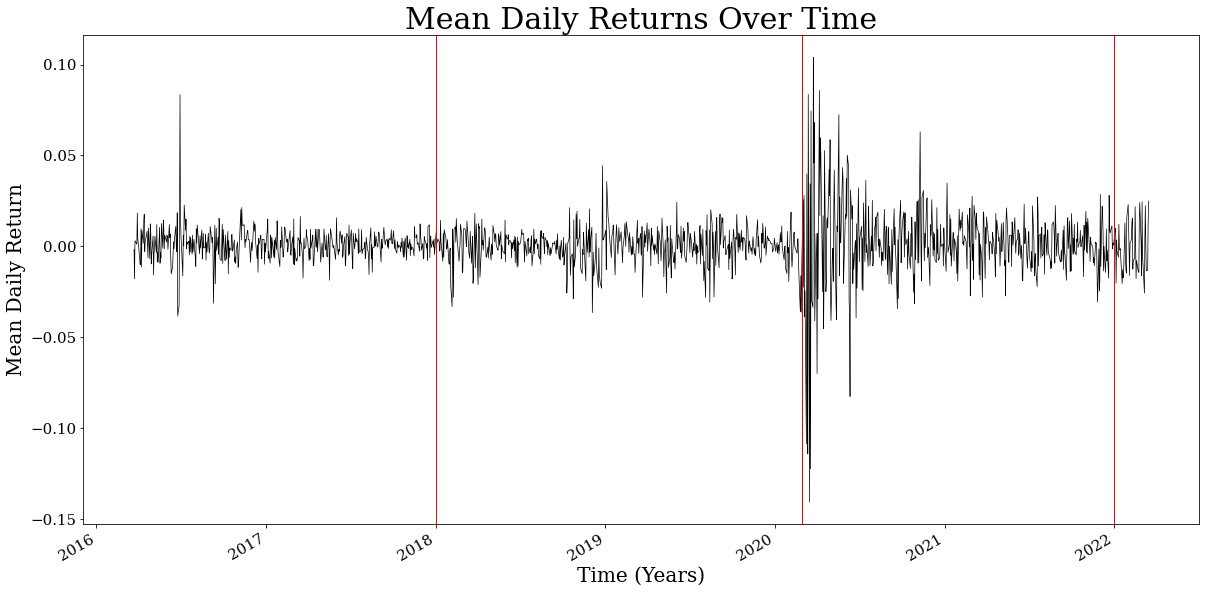

variance of the intervals
0.00009286120000000000
0.00051536910000000004


In [6]:
plt.rc('font', family='serif')
plt.rc('xtick')
plt.rc('ytick')

fig = plt.figure(figsize=(fig_height, 10))
ax = fig.add_subplot(1, 1, 1)

returns_companies = df_returns.mean(axis=1)
returns_companies.plot(color="k", linewidth=0.7)

ax.set_xlabel('Time (Years)', fontsize=label_size)
ax.set_ylabel('Mean Daily Return', fontsize=label_size)
ax.set_title('Mean Daily Returns Over Time', fontsize=title_size)
plt.xticks(fontsize=tick_size)
plt.yticks(fontsize=tick_size)


for int_ in interval_borders:
    plt.axvline(x = int_, color = 'red', label = 'DD Event time', linewidth = 1)

plt.savefig(DATA_LOCATION +"visualisations/NYSE_daily_returns.svg", dpi=600, bbox_inches='tight')
plt.show()
# get var for the intervals
print("variance of the intervals")
print(f'{round(returns_companies.loc[interval_borders[0]:interval_borders[1]].var(),10):.20f}')
print(f'{round(returns_companies.loc[interval_borders[1]:interval_borders[2]].var(), 10):.20f}')


### Remove companies outside of the timeframe of interest

In [7]:
# this is the interval where filings are interesting to us
earliest_timestamp = list(investigation_periods.values())[0][0]
latest_timestamp = list(investigation_periods.values())[-1][1]
filings_removed = 0
filings_total = 0

for company in tqdm(companies):
    insider_data_df = company.insider_data_df
    filing_dates = insider_data_df.FilingDate.apply(lambda x: x.floor("d"))
    mask = (filing_dates >= earliest_timestamp) & (filing_dates <= latest_timestamp)
    company.insider_data_df = company.insider_data_df[mask]
    filings_removed += (~mask).sum()
    filings_total += mask.shape[0]

print("Total filings: {}".format(filings_total))
print("Removed {} filings".format(filings_removed))
print("Remaining filings: {}".format(filings_total - filings_removed))

100%|██████████| 1534/1534 [00:07<00:00, 199.69it/s]

Total filings: 290664
Removed 0 filings
Remaining filings: 290664


### Investigate Filing Trade Lag Times

In [8]:
print("get filing lags ...")

lags = []
for company in tqdm(companies):
    lag = UASC.analyse_single_company(company)
    lags.append(lag)


get filing lags ...


 17%|█▋        | 261/1534 [00:06<00:30, 41.69it/s]


KeyboardInterrupt: 

In [ ]:
filing_trade_lags = sum(lags, [])

lag_in_hours = np.asarray(filing_trade_lags)
negative_lag_mask = lag_in_hours < 0
positive_lag = lag_in_hours[~negative_lag_mask]
in_21_days = positive_lag < 21*24
relevant_lag = positive_lag[in_21_days]
print(f"Negative lag for {negative_lag_mask.sum()} out of {len(negative_lag_mask)} trades.")
print(f"Lag longer than 21 days for {len(positive_lag) - len(relevant_lag)} out of {len(negative_lag_mask)} trades.")
print(f"Eligible trades: {len(relevant_lag)} out of {len(negative_lag_mask)} trades.")

fig = plt.figure(figsize=(fig_height, 7))
ax = fig.add_subplot(1, 1, 1)
plt.hist(np.log(positive_lag), bins="auto")
ax.set_xlabel('Time (Log(Hours))', fontsize=label_size)
ax.set_ylabel('Trades', fontsize=label_size)
ax.set_title('Distribution of Log Lag Times between Filing and Trade', fontsize=title_size)

plt.xticks(fontsize=tick_size)
plt.yticks(fontsize=tick_size)

plt.axvline(x = 0, color = 'red', label = 'Zero', linewidth = 1)
plt.axvline(x = np.log(21*24), color = 'red', label = 'Threshold', linewidth = 1)
plt.savefig(DATA_LOCATION +"visualisations/log_transformed_lags.svg", dpi=600, bbox_inches='tight')
plt.show()

without_outliers = positive_lag[positive_lag < 24*21]

fig = plt.figure(figsize=(fig_height, 5))
ax = fig.add_subplot(1, 1, 1)
plt.hist(without_outliers, bins="auto")
plt.xticks(np.arange(0, max(without_outliers) + 1, 24))
ax.set_xlabel('Time (Hours)', fontsize=label_size)
ax.set_ylabel('Trades', fontsize=label_size)
ax.set_title('Distribution of Lag Times between Filing and Trade', fontsize=title_size)

plt.xticks(fontsize=tick_size)
plt.yticks(fontsize=tick_size)

plt.savefig(DATA_LOCATION +"visualisations/lags_without_outliers.svg", dpi=600, bbox_inches='tight')
plt.show()

### Drop companies with lags longer than 21 days or negative lags

In [ ]:
removed_lags = 0
remaining_lags = 0

for lags_c, company in tqdm(zip(lags, companies)):
    lags_c = np.asarray(lags_c)
    mask_eligible = (lags_c >= 0) & (lags_c <= 21*24)
    company.insider_data_df = company.insider_data_df[mask_eligible]
    removed_lags += (~mask_eligible).sum()
    remaining_lags += mask_eligible.sum()

print(f"Total trades: {removed_lags + remaining_lags}")
print(f"Removed {removed_lags} trades.")
print(f"Remaining {remaining_lags} trades.")


## Demonstrate process for a single event

### Define windows

#### Our data contains multiple companies. A single company contains multiple filings and each filing is an event

![alt text](assets/images/windows.png "Title")

In [ ]:
## Constants defining how long both Estimation Window and Event Window are
### Probably also input parameters to a function call, as we need loops later...
L1_length = 100
L2_length = 41 # TODO +-20 days = 40 days, right?
L2_length = L2_length -1 # this is so our calculation works as before, could be done cleaner

## Calculate ARs

### Now that we have seen the process for one single filing, let us do the same for all filings in all companies


In [ ]:
# Initialize testing
logging.getLogger().setLevel(logging.ERROR)
# Helpers
multiind, data, data_errors = [], [], []
estimation_window_market_return_list, event_window_market_return_list, eps_list = [], [], []
n_companies = len(companies)


#for j in tqdm(range(len(companies[:200]))):
for j in tqdm(range(len(companies))):
    # Get information from said company
    company = companies[j]
    company_return = company.return_index_df
    
    n_filings = len(company.insider_data_df)
    # Go through all filings
    for i in company.insider_data_df.FilingDate.index:

        # Find our event date from filing
        filing_date = company.insider_data_df.FilingDate[i]
        event_timestamp = filing_date.floor("d")

        checks = data_checks.run(L1_length, L2_length, event_timestamp, company_return)
        if checks:
            #print(checks[1])
            data_errors.append(checks[0])
            continue
   
        ## Proceed to find periods
        T0_, T1_, T2_, T0, T1, T2, ERRORS, msg = determine_T0_T1_T2.run(L1_length, L2_length, event_timestamp, company_return)
        if ERRORS:
            #print(msg)
            data_errors.append(ERRORS)
            continue
            
        ## Cut timeseries to the relevant periods, and split them
        windows = cut_timeseries.run(company_return, T0, T1, T2)
        estimation_window_market_return, estimation_window_company_return,event_window_market_return, event_window_company_return = windows
        alpha, beta, eps = calculate_coefficients.run(estimation_window_market_return, estimation_window_company_return) # TODO change back to calculate_coefficients.run or check validity
        ## Calculate the abnormal returns
        abnormal_return = event_window_company_return - alpha - beta*event_window_market_return
        
        ## Append to results
        estimation_window_market_return_list.append(estimation_window_market_return)
        event_window_market_return_list.append(event_window_market_return)
        eps_list.append(eps)
        multiind.append((company.ticker, i, company.insider_data_df.TradeType[i], event_timestamp))
        data.append(abnormal_return)

In [ ]:
# process and save abnormal returns
df_abnormal_returns = pd.DataFrame.from_records([d.reset_index(drop=True) for d in data])
df_abnormal_returns.index = pd.MultiIndex.from_tuples(multiind, names=["Company", "i", "TradeType", "event_timestamp"])

In [ ]:
df_abnormal_returns

In [ ]:
df_estimation_window_market_return = pd.DataFrame.from_records([d.reset_index(drop=True) for d in estimation_window_market_return_list])
df_estimation_window_market_return.index = pd.MultiIndex.from_tuples(multiind, names=["Company", "i", "TradeType", "event_timestamp"])

In [ ]:
df_event_window_market_return = pd.DataFrame.from_records([d.reset_index(drop=True) for d in event_window_market_return_list])
df_event_window_market_return.index = pd.MultiIndex.from_tuples(multiind, names=["Company", "i", "TradeType", "event_timestamp"])

In [ ]:
df_eps = pd.DataFrame.from_records([d.reset_index(drop=True) for d in eps_list])
df_eps.index = pd.MultiIndex.from_tuples(multiind, names=["Company", "i", "TradeType", "event_timestamp"])

### Show the reasons filings were dropped

In [ ]:
errors_df = pd.DataFrame.from_records(data_errors)
errors_agg = errors_df.sum(axis=0)

In [ ]:
# add earlier filtering
errors_agg["event not in overall time frame"] = filings_removed
errors_agg["negative lags"] = negative_lag_mask.sum()
errors_agg["more than 21 days lag"] = len(positive_lag) - len(relevant_lag)

In [ ]:
errors_agg = pd.DataFrame(errors_agg)
errors_agg.index.name = "Reason"
errors_agg.columns = ["Count"]

In [ ]:
print(errors_agg.astype(int).reset_index().to_latex(index=False))

In [ ]:
print(errors_agg.sum())

In [ ]:
# if dir does not exist creat it
if not os.path.exists(f"data/{NAME}/calculate_AR_results/"):
    os.mkdir(f"data/{NAME}/calculate_AR_results/")


df_abnormal_returns.to_pickle(f"data/{NAME}/calculate_AR_results/df_abnormal_returns.pkl")
df_estimation_window_market_return.to_pickle(f"data/{NAME}/calculate_AR_results/df_estimation_window_market_return.pkl")
df_event_window_market_return.to_pickle(f"data/{NAME}/calculate_AR_results/df_event_window_market_return.pkl")
df_eps.to_pickle(f"data/{NAME}/calculate_AR_results/df_eps.pkl")

with open(f"data/{NAME}/calculate_AR_results/companies.pkl", "wb") as f:
    pickle.dump(companies, f)